In [ ]:
# EXPERIMENT 3
# OVERCONTACT - PREDIKCIA T2/T1 (POMER EFEKTIVNYCH TEPLOT) ZO SVETELNYCH KRIVIEK FILTRA BESELL_U BEZ UMELEHO SUMU
# ARCHITEKTURA LSTM + 1D CNN c.2

In [1]:
# BLOK 1
# Importovanie kniznic.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Input, Dense, LSTM, Dropout, Flatten
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

np.random.seed(1234)

In [2]:
# BLOK 2
# Nacitanie syntetickych dat.

data = pd.read_pickle("overcontact_Bessell_U.pkl") 

In [3]:
# BLOK 3
# Vyber a priprava dat. Rozdelenie dat na trenovaciu a testovaciu mnozinu v pomere 80:20.

data["t2/t1"]=data["secondary__t_eff"]/data["primary__t_eff"]

y=np.array(data["t2/t1"])
X=[]
for row in data["Bessell_U"]:
    X.append(row)
X=np.array(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

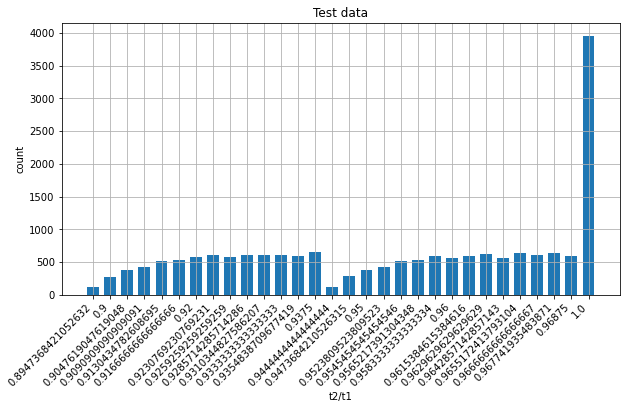

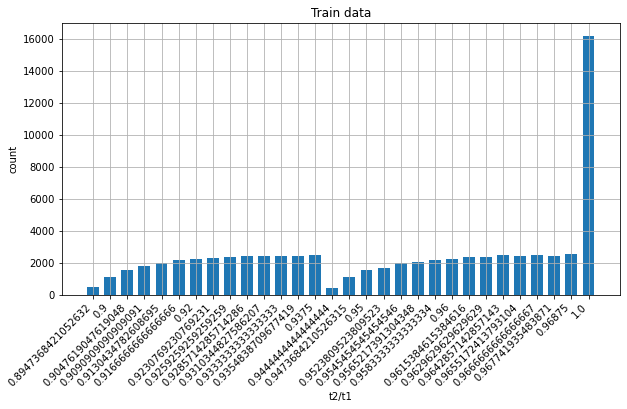

In [4]:
# BLOK 4
# Vykreslenie grafov distribucie hodnot trenovacej a testovacej mnoziny.

y1,y2=np.unique(y_test, return_counts=True)
y3,y4=np.unique(y_train, return_counts=True)
y12=pd.DataFrame(data={"value": y1, "count": y2})
y34=pd.DataFrame(data={"value": y3, "count": y4})

fig = plt.figure(figsize=(10,5))
plt.bar(y12["value"].array.astype(str), y12["count"], width=0.7)
plt.xticks(rotation=45, ha='right')
plt.title("Test data")
plt.xlabel("t2/t1")
plt.ylabel("count")
plt.grid(b="on")
plt.show()

fig = plt.figure(figsize=(10,5))
plt.bar(y34["value"].array.astype(str), y34["count"], width=0.7)
plt.xticks(rotation=45, ha='right')
plt.title("Train data")
plt.xlabel("t2/t1")
plt.ylabel("count")
plt.grid(b="on")
plt.show()

In [8]:
# BLOK 5
# Vytvorenie architektury modelu na predikciu t2/t1. Vypis architektury modelu. Spustenie trenovania.

inputs = Input(shape=(400,1))
b = Conv1D(64, kernel_size = 3, padding = "valid")(inputs)
b = MaxPooling1D(2)(b)
b = Dropout(0.2)(b)
b = LSTM(64, return_sequences=True)(b)
b = Flatten()(b)
b = Dense(64, activation='relu')(b)
x = Dense(32, activation='relu')(b)
output = Dense(1, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
print(model.summary())

saved_model = "sT_pT_over_lstm_1dcnn_c2.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=15)
callbacks_list = [checkpoint, early]

history=model.fit(X_train, y_train, validation_split=0.1, epochs=150, verbose=1, callbacks = callbacks_list, batch_size=64)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 400, 1)]          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 398, 64)           256       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 199, 64)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 199, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 199, 64)           33024     
                                                                 
 flatten_1 (Flatten)         (None, 12736)             0         
                                                           

In [6]:
# BLOK 6
# Nacitanie a vyhodnotenie modelu na testovacich datach.

model=load_model("sT_pT_over_lstm_1dcnn_c2.hdf5")
model.evaluate(X_test, y_test)

584/584 [==============================] - 18s 30ms/step - loss: 1.8234e-04 - mae: 0.0098 - mape: 1.0294


[0.00018233602168038487, 0.009803812019526958, 1.0293738842010498]

In [7]:
# BLOK 7
# Vysledky predikcie na testovacich krivkach.

y_pred=model.predict(X_test)
y_pred=np.reshape(y_pred, len(y_pred))
df_pred=pd.DataFrame(data={'y_test': y_test, 'y_predict': y_pred})
df_pred["diff"]=df_pred["y_test"]-df_pred["y_predict"]
df_pred["abs_diff"]=abs(df_pred["diff"])
df_pred["re"]=df_pred["abs_diff"]/df_pred["y_test"]

print("pocet kriviek s relativnou chybou < 5%: " + str(len(df_pred[df_pred["re"]<0.05])) +
      "\npocet kriviek s relativnou chybou < 2,5%: " + str(len(df_pred[df_pred["re"]<0.025])) +
      "\npocet kriviek s relativnou chybou < 1%: " + str(len(df_pred[df_pred["re"]<0.01])) +
      "\npocet kriviek s relativnou chybou < 10%: " + str(len(df_pred[df_pred["re"]<0.1])))

pocet kriviek s relativnou chybou < 5%: 18590
pocet kriviek s relativnou chybou < 2,5%: 16989
pocet kriviek s relativnou chybou < 1%: 11327
pocet kriviek s relativnou chybou < 10%: 18659
